#Classification d’âge avec une Approche de Régression

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq "/content/drive/MyDrive/UTKFace.zip" -d "/content/UTKFace"

In [72]:
# Importation
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow et Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    Input, RandomFlip, RandomRotation, RandomZoom, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Importation de scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error, accuracy_score

In [3]:
DATA_DIR = "/content/UTKFace/UTKFace"

In [8]:
#Redimensionnement
IMG_HEIGHT = 64
IMG_WIDTH = 64

## Extraction des âges

L’objectif de cette étape est de préparer les données du dataset UTKFace afin d’entraîner un modèle de régression qui prédira l’âge des individus à partir de leurs images faciales.

Contrairement à une classification binaire (comme la distinction homme/femme), il s’agit ici d’une prédiction continue de l’âge, qui sera ensuite convertie en classes d’âges pour l’évaluation.

Avant d’entraîner le modèle, il est important de comprendre comment les âges sont répartis dans le dataset.

Les images du dataset UTKFace sont nommées sous la forme "âge_genre_ethnie_dateNaiss.jpg".


La première information dans le nom de fichier est l’âge de la personne sur la photo.

La première partie du code extrait donc l’âge à partir du nom du fichier :

In [6]:
# Extraction des âges depuis le nom des fichiers
ages = []
for filename in os.listdir(DATA_DIR):
    try:
        age = int(filename.split("_")[0])  # Extraction de l'âge (1ère partie du nom de fichier)
        ages.append(age)
    except ValueError:
        pass  # Ignorer les fichiers mal formatés


Ce code parcourt tous les fichiers du dataset et extrait l’âge,
ignore les fichiers mal formatés qui pourraient ne pas contenir l’information d’âge sous le bon format et stocke les âges dans une liste pour une analyse statistique.

## Visualisation sur la répartition des âges

Une fois la liste des âges extraite, un histogramme est généré pour observer la distribution des âges dans le dataset.

L’analyse de la distribution des âges dans le dataset UTKFace met en évidence plusieurs difficultés potentielles qui peuvent impacter la performance du modèle de régression :

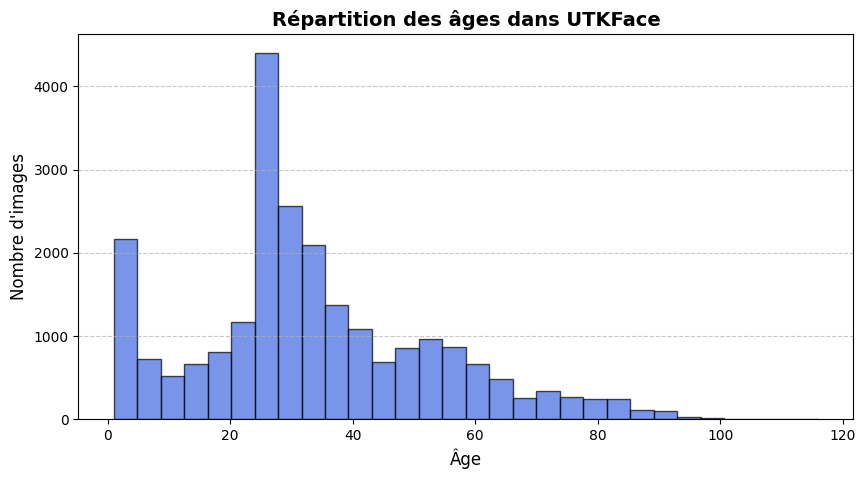

In [7]:
# Création de l'histogramme
plt.figure(figsize=(10, 5))
plt.hist(ages, bins=30, color="royalblue", edgecolor="black", alpha=0.7)

# Personnalisation du graphique
plt.title("Répartition des âges dans UTKFace", fontsize=14, fontweight="bold")
plt.xlabel("Âge", fontsize=12)
plt.ylabel("Nombre d'images", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Affichage
plt.show()

Dans l'histogramme ci-joint, il est possible d’observer une forte concentration d’images autour des jeunes adultes (environ 20 ans), tandis que les âges plus élevés sont moins représentés. Cette répartition peut influencer l’apprentissage du modèle, car celui-ci risque d’être moins performant pour les classes sous-représentées (ex. les personnes âgées).

Par ailleurs, Les âges du dataset sont fournis à partir des noms des fichiers et peuvent ne pas être parfaitement fiables.

En effet, un âge biologique ne correspond pas toujours à un âge visuel, certaines personnes paraissant plus jeunes ou plus âgées que leur âge réel.

De plus, il est difficile pour un modèle de capturer des indices précis pour différencier un âge de 30 ans et un âge de 32 ans, car les différences physiques sont souvent faibles.

Les facteurs externes (lumière, expressions faciales, maquillage, qualité d’image) peuvent influencer la perception de l’âge et perturber les prédictions.

UTKFace contient également des informations sur le genre et l’origine ethnique des individus.

Si certaines catégories d’âges sont sur-représentées par un certain groupe démographique, le modèle pourrait apprendre des biais non désirés : Le modèle pourrait associer des caractéristiques spécifiques (ex. couleur de peau, traits du visage) à certaines tranches d’âges, ce qui introduirait un biais dans la prédiction.

Une faible diversité dans les âges élevés pourrait limiter la capacité du modèle à généraliser sur différentes populations.

## Chargement et Prétraitement des Images

Une fois les âges extraits, les images doivent être chargées et préparées pour l’entraînement du modèle.



In [9]:
def load_data_age(data_dir=DATA_DIR, img_size=(64,64)):
    X = []
    y = []
    file_names = os.listdir(data_dir)

    for file in file_names:
        parts = file.split("_")
        if len(parts) > 1:
            try:
                age = int(parts[0])
            except:
                continue

            img_path = os.path.join(data_dir, file)
            img = cv2.imread(img_path)
            if img is None:
                continue

            # RGB + Resize + Normalisation
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img = img.astype("float32") / 255.0

            X.append(img)
            y.append(age)

    return np.array(X), np.array(y)

X, y = load_data_age(DATA_DIR, (IMG_HEIGHT, IMG_WIDTH))
print("Nombre d'images chargées :", len(X))
print("Dimension de X :", X.shape, "Dimension de y :", y.shape)


Nombre d'images chargées : 23708
Dimension de X : (23708, 64, 64, 3) Dimension de y : (23708,)


Ce code effectue:

- Un chargement de chaque image du dataset en lisant son chemin d’accès.
- Une extraction de l’âge à partir du nom du fichier.
- Une conversion des images en format RGB, (car cv2.imread() charge les images en BGR par défaut.)
- Un redimensionnement en 64×64 pixels, afin de réduire la taille mémoire et uniformiser les entrées du modèle.
- Une normalisation des pixels entre [0,1], pour faciliter l’entraînement et accélère la convergence.

## Division du jeu de données

Une fois les images et leurs âges récupérés, le dataset est divisé en trois parties :

In [12]:
# Split Train / Val / Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42
)

print("Taille du jeu d'entraînement :", X_train.shape, len(y_train))
print("Taille du jeu de validation :", X_val.shape, len(y_val))
print("Taille du jeu de test :", X_test.shape, len(y_test))


Taille du jeu d'entraînement : (15172, 64, 64, 3) 15172
Taille du jeu de validation : (3794, 64, 64, 3) 3794
Taille du jeu de test : (4742, 64, 64, 3) 4742


- L’entraînement permet au modèle d’apprendre sur une grande quantité de données.
- La validation permet d’ajuster l’entraînement et de détecter si le modèle commence à mémoriser les données (surapprentissage).
- Le test est une évaluation finale sur un ensemble de données non utilisées, afin de mesurer la généralisation du modèle.

## Définition des tranches d'âges

Bien que le modèle entraîne une régression continue pour prédire l’âge exact, l’évaluation sera effectuée en classant les prédictions dans des tranches d’âges, conformément aux consignes de la SAE.

In [13]:
# Définition des Tranches d'Âge
age_brackets = [
    (0,3), (4,9), (10,19), (20,29), (30,39),
    (40,49), (50,59), (60,69), (70,79), (80,116)
]

In [14]:
def bracket_index(age):
    for i, (low, high) in enumerate(age_brackets):
        if low <= age <= high:
            return i
    return None

En effet, les erreurs en régression peuvent être trop pénalisantes si le modèle prédit un âge légèrement incorrect (ex. 21 ans au lieu de 22 ans).

Ainsi, en regroupant les âges en catégories cohérentes, on réduit l’impact des erreurs.

# Implémentation 1

L’approche effectuée pour cette seconde partie repose sur une adaptation du modèle V2, utilisé précédemment pour la classification du genre.

Le modèle de classification a été modifié pour fonctionner en régression, c'est-à-dire qu'il prédit une valeur continue (l'âge).

Le modèle ne prédit plus une probabilité de classe (sigmoid), mais une valeur continue représentant l'âge.


La dernière couche contient un seul neurone sans activation (Dense(1)).

La Mean Absolute Error (MAE) est utilisée, comme suggéré dans la consigne.

Pour comparer les performances du modèle, les âges prédits seront convertis en classes d’âges définies et évalués via l’accuracy.

In [15]:
# Modèle CNN pour la régression d'âge basé sur la V1

def build_model_age_v1(input_shape=(64, 64, 3)):
    model = Sequential([
        # Data Augmentation
        Input(shape=input_shape),
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),

        # Bloc 1
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 2
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 3
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 4
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        # Sortie régression => 1 neurone (pas d'activation)
        Dense(1)
    ])

    # Compilation : Utilisation de MAE comme fonction de perte pour la régression
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mae',  # Mean Absolute Error pour la régression
        metrics=['mae']
    )
    return model

# Instanciation du modèle
model_v1 = build_model_age_v1((IMG_HEIGHT, IMG_WIDTH, 3))
model_v1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │              

 Total params: 361,313 (1.38 MB)

 Trainable params: 360,577 (1.38 MB)

 Non-trainable params: 736 (2.88 KB)

Ici, aucune activation (sigmoid ou softmax) n’est appliquée, car l’objectif est de prédire une valeur numérique et non une classe.

In [16]:
# Callbacks: EarlyStopping + ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

# Entraînement

history_v1 = model_v1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 139s 273ms/step - loss: 29.4102 - mae: 29.4102 - val_loss: 12.2430 - val_mae: 12.2430 - learning_rate: 0.0010
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 113s 239ms/step - loss: 12.6700 - mae: 12.6700 - val_loss: 12.3550 - val_mae: 12.3550 - learning_rate: 0.0010
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 144s 244ms/step - loss: 11.6142 - mae: 11.6142 - val_loss: 9.8625 - val_mae: 9.8625 - learning_rate: 0.0010
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 156s 273ms/step - loss: 10.6106 - mae: 10.6106 - val_loss: 11.6403 - val_mae: 11.6403 - learning_rate: 0.0010
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 127s 267ms/step - loss: 10.0847 - mae: 10.0847 - val_loss: 8.9926 - val_mae: 8.9926 - learning_rate: 0.0010
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 131s 245ms/step - loss: 9.6378 - mae: 9.6378 - val_loss: 10.5826 - val_mae: 10.5826 - learning_rate: 0.0010
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 139s 239ms/step - loss: 9.2769 - mae: 9.2769 - val_loss: 8.0161 - 

### Analyse des métriques

Dans cette partie, nous avons choisis de visualiser le jeu de validation pour surveiller l’apprentissage et éviter l’overfitting ainsi que le jeu test pour mesurer la vraie performance du modèle sur des données non vues.

Le jeu d'entraînement est utilisé pour ajuster les paramètres du modèle.
Les performances sur train ne sont pas représentatives de la capacité du modèle à généraliser.
Une très bonne performance sur train ne signifie pas nécessairement que le modèle fonctionne bien sur des données inconnues.

In [51]:
#  Évaluation sur le jeu de TEST
test_loss_v1, test_mae_v1 = model_v1.evaluate(X_test, y_test, verbose=0)
print(f"[V1] Test Loss (MAE): {test_loss_v1:.4f}")

# Conversion des âges prédits en catégories (tranches d'âge) pour TEST
y_pred_v1_test = model_v1.predict(X_test).flatten()
y_pred_brackets_v1_test = [bracket_index(int(round(age_pred))) for age_pred in y_pred_v1_test]
y_test_brackets_v1 = [bracket_index(int(age_true)) for age_true in y_test]

# Suppression des valeurs None (hors tranches définies)
valid_idx_test = [i for i, br in enumerate(y_pred_brackets_v1_test) if br is not None]
y_pred_brackets_v1_test_valid = np.array([y_pred_brackets_v1_test[i] for i in valid_idx_test], dtype=int)
y_test_brackets_v1_valid = np.array([y_test_brackets_v1[i] for i in valid_idx_test], dtype=int)

#  Accuracy sur TEST
acc_brackets_v1_test = accuracy_score(y_test_brackets_v1_valid, y_pred_brackets_v1_test_valid)
print("\n[V1] Accuracy  :", acc_brackets_v1_test)

#  Rapport de classification sur TEST
print("\n[V1] Classification report sur les tranches d'âge sur TEST:")
print(classification_report(y_test_brackets_v1_valid, y_pred_brackets_v1_test_valid))

[V1] Test Loss (MAE): 7.0131
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step

[V1] Accuracy  : 0.45268207588312254

[V1] Classification report sur les tranches d'âge sur TEST:
              precision    recall  f1-score   support

           0       0.74      0.44      0.55       241
           1       0.45      0.36      0.40       241
           2       0.32      0.35      0.34       296
           3       0.63      0.66      0.64      1456
           4       0.38      0.47      0.42       881
           5       0.26      0.29      0.27       474
           6       0.40      0.30      0.34       482
           7       0.26      0.24      0.25       250
           8       0.20      0.20      0.20       139
           9       0.55      0.33      0.41       126

    accuracy                           0.45      4586
   macro avg       0.42      0.36      0.38      4586
weighted avg       0.46      0.45      0.45      4586



Les jeunes adultes (20-29 ans) sont les mieux prédits :

  - Nous avons une meilleure précision (0.63), un rappel élevé (0.66), et un meilleur F1-score (0.64).
  
  Cela est probablement dû au grand nombre d’exemples dans cette classe (1456 images), ce qui permet au modèle d’apprendre efficacement les caractéristiques faciales associées à cet âge.

Les enfants et adolescents (0-19 ans) ont une performance variable :

  - (0-3 ans) : Nous avons une précision correcte (0.74) mais un faible rappel (0.44), ce qui indique des faux négatifs fréquents (de nombreux bébés sont classés dans d’autres catégories).

  - (4-9 ans) et (10-19 ans) : Nous observons une précision et un rappel moyens (~0.32 à 0.45), ce qui suggère des confusions fréquentes avec les âges voisins.

Les tranches d’âge supérieures à 30 ans ont des scores faibles :

  - Une précision modérée (0.38 à 0.40) et un rappel faible (0.20 à 0.30), indiquant que ces âges sont souvent mal prédits.
  
Plus l’âge augmente, plus le F1-score diminue, ce qui confirme la difficulté du modèle à bien estimer les âges avancés.

Les personnes âgées (70+ ans) sont mal classées :

  - (70-79 ans) : une très faible précision (0.20) et un faible rappel (0.20).
  - (80-116 ans) : La précision (0.55) est relativement correcte, mais le rappel (0.33) reste faible, ce qui signifie que beaucoup de personnes âgées sont classées dans des tranches inférieures.


Ainsi, les classes ayant le plus d’exemples (20-29 ans) sont les mieux prédites, confirmant un biais du modèle en faveur des classes majoritaires.

Les âges extrêmes (0-9 ans et 70+ ans) sont souvent mal classés, probablement à cause du faible nombre d’exemples dans ces tranches.

Le modèle fait souvent des erreurs entre classes voisines, ce qui est logique étant donné la difficulté à distinguer des âges très proches.


In [50]:
# Évaluation sur le jeu de VALIDATION
val_loss_v1, val_mae_v1 = model_v1.evaluate(X_val, y_val, verbose=0)
print(f"[V1] Validation Loss (MAE): {val_loss_v1:.4f}")

y_pred_v1_val = model_v1.predict(X_val).flatten()
y_pred_brackets_v1_val = [bracket_index(int(round(age_pred))) for age_pred in y_pred_v1_val]
y_val_brackets_v1 = [bracket_index(int(age_true)) for age_true in y_val]

# Suppression des valeurs None
valid_idx_val = [i for i, br in enumerate(y_pred_brackets_v1_val) if br is not None]
y_pred_brackets_v1_val_valid = np.array([y_pred_brackets_v1_val[i] for i in valid_idx_val], dtype=int)
y_val_brackets_v1_valid = np.array([y_val_brackets_v1[i] for i in valid_idx_val], dtype=int)

# Accuracy sur VALIDATION
acc_brackets_v1_val = accuracy_score(y_val_brackets_v1_valid, y_pred_brackets_v1_val_valid)
print("\n[V1] Accuracy  sur VALIDATION :", acc_brackets_v1_val)

# Rapport de classification sur VALIDATION
print("\n[V1] Classification report sur les tranches d'âge sur VALIDATION:")
print(classification_report(y_val_brackets_v1_valid, y_pred_brackets_v1_val_valid))


[V1] Validation Loss (MAE): 6.8797
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step

[V1] Accuracy  sur VALIDATION : 0.4623362445414847

[V1] Classification report sur les tranches d'âge sur VALIDATION:
              precision    recall  f1-score   support

           0       0.78      0.47      0.58       193
           1       0.42      0.34      0.38       171
           2       0.30      0.32      0.31       253
           3       0.62      0.68      0.65      1159
           4       0.39      0.44      0.42       736
           5       0.31      0.34      0.32       377
           6       0.38      0.31      0.34       337
           7       0.27      0.23      0.25       212
           8       0.27      0.28      0.28       114
           9       0.60      0.38      0.46       112

    accuracy                           0.46      3664
   macro avg       0.44      0.38      0.40      3664
weighted avg       0.47      0.46      0.46      3664



Ici, la MAE est légèrement meilleure que sur l'ensemble de test, ce qui indique que le modèle généralise relativement bien et ne souffre pas d’un surapprentissage sévère.

De même ici, l’accuracy des tranches d’âges est faible (≈ 45-46 %)

L’accuracy  sur validation (0.46) est proche de celle du test (0.45), ce qui indique une bonne stabilité du modèle.

La macro-average du F1-score est un peu meilleure en validation (0.44 vs 0.42 sur test), suggérant une légère amélioration des performances moyennes sur les tranches d’âge.

Les âges extrêmes restent le point faible du modèle.

### Visualisations : diagrammes de points, courbes d'apprentissage

Ces scatters plot représentent la comparaison entre l’âge réel (axe des abscisses) et l’âge prédit par le modèle (axe des ordonnées) sur l’ensemble des jeux de test et de validation.

La ligne rouge en pointillés représente la diagonale parfaite, où l’âge prédit serait exactement égal à l’âge réel.

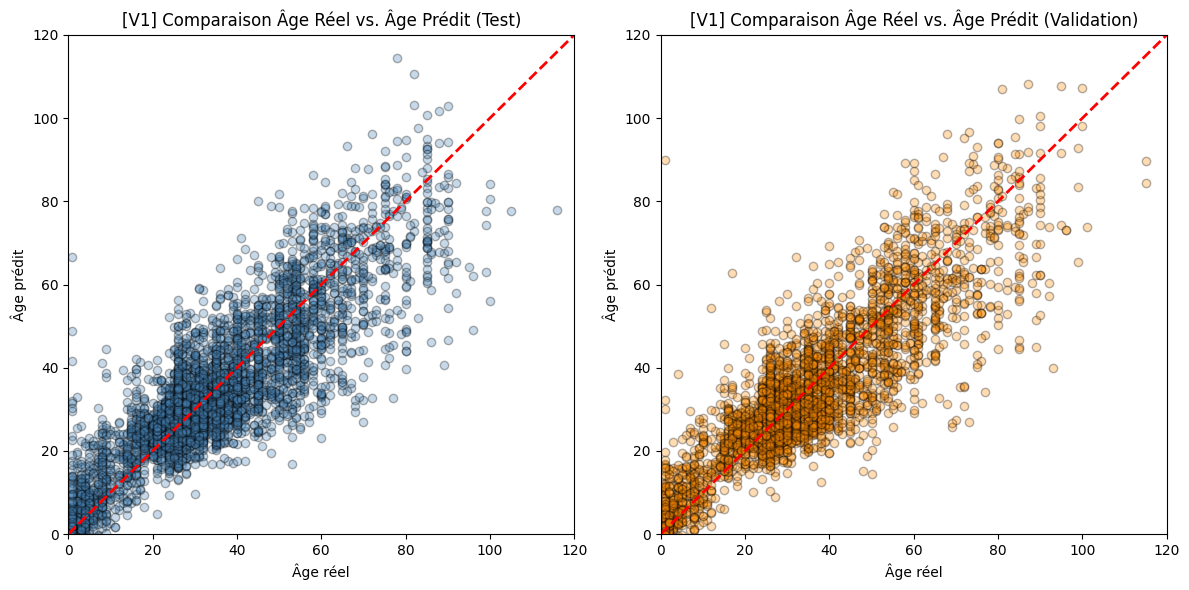

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))  # 1 ligne, 2 colonnes

# Scatter plot : Comparaison âge réel vs âge prédit (TEST)
axes[0].scatter(y_test, y_pred_v1_test, alpha=0.3, color='steelblue', edgecolor='k')
axes[0].plot([0,120],[0,120], color='red', linestyle='--', linewidth=2)  # Diagonale parfaite
axes[0].set_xlabel("Âge réel")
axes[0].set_ylabel("Âge prédit")
axes[0].set_title("[V1] Comparaison Âge Réel vs. Âge Prédit (Test)")
axes[0].set_xlim([0,120])
axes[0].set_ylim([0,120])

# Scatter plot : Comparaison âge réel vs âge prédit (VALIDATION)
axes[1].scatter(y_val, y_pred_v1_val, alpha=0.3, color='darkorange', edgecolor='k')
axes[1].plot([0,120],[0,120], color='red', linestyle='--', linewidth=2)  # Diagonale parfaite
axes[1].set_xlabel("Âge réel")
axes[1].set_ylabel("Âge prédit")
axes[1].set_title("[V1] Comparaison Âge Réel vs. Âge Prédit (Validation)")
axes[1].set_xlim([0,120])
axes[1].set_ylim([0,120])

plt.tight_layout()  # Ajuste l'espacement entre les graphiques
plt.show()

Pour les deux graphiques, la majorité des points se trouvent proches de la diagonale, ce qui signifie que le modèle capte une tendance générale entre l’âge réel et l’âge prédit.

Cela confirme que le modèle n’est pas complètement aléatoire et qu’il a appris à estimer approximativement l’âge.

De plus, plus l’âge augmente, plus la dispersion est forte. Cela indique que le modèle est moins précis pour les âges avancés.


Pour les personnes âgées (70+ ans), beaucoup de points se situent en dessous de la diagonale : Le modèle a tendance à prédire un âge inférieur à l’âge réel.


Pour les jeunes (0-40 ans), le modèle semble mieux suivre la diagonale, même si des erreurs existent.


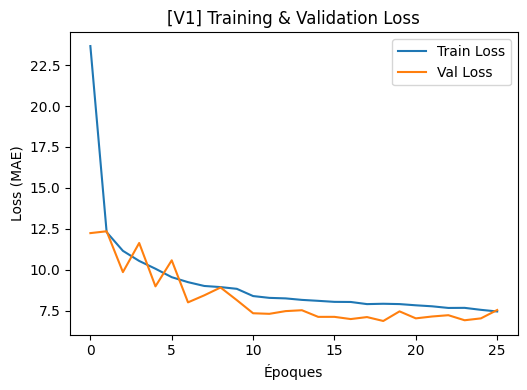

In [54]:
# Courbes d'apprentissage (Loss et MAE sur TRAIN et VALIDATION)
plt.figure(figsize=(10, 4))

# Courbe de la Loss (Erreur MAE)
plt.subplot(1, 2, 1)
plt.plot(history_v1.history['loss'], label='Train Loss')
plt.plot(history_v1.history['val_loss'], label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.title('[V1] Training & Validation Loss')


plt.tight_layout()
plt.show()


Les courbes d’entraînement et de validation restent proches, ce qui indique peu de surapprentissage.

La diminution ralentit après ~10-15 époques, suggérant une convergence du modèle.

Le modèle a une bonne dynamique d’apprentissage mais atteint rapidement une limite en termes de précision.



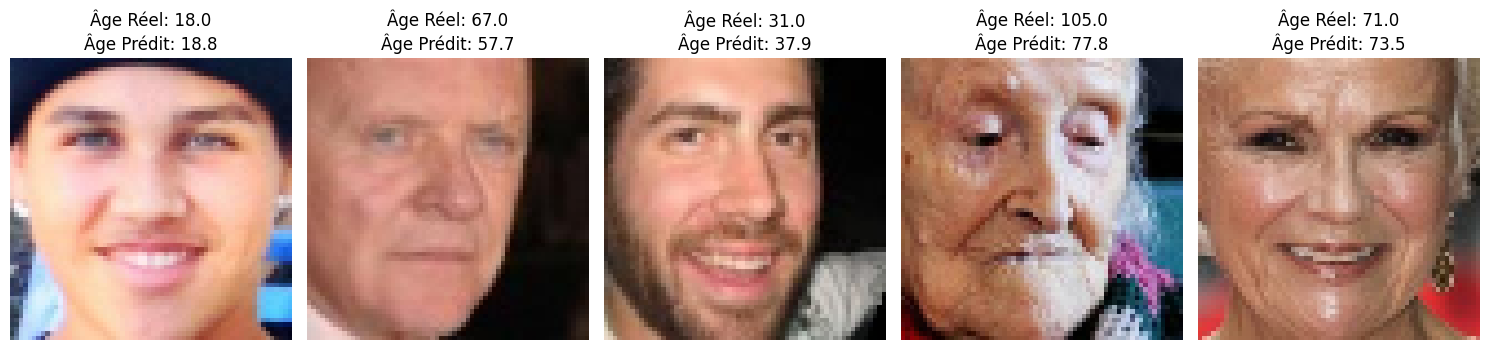

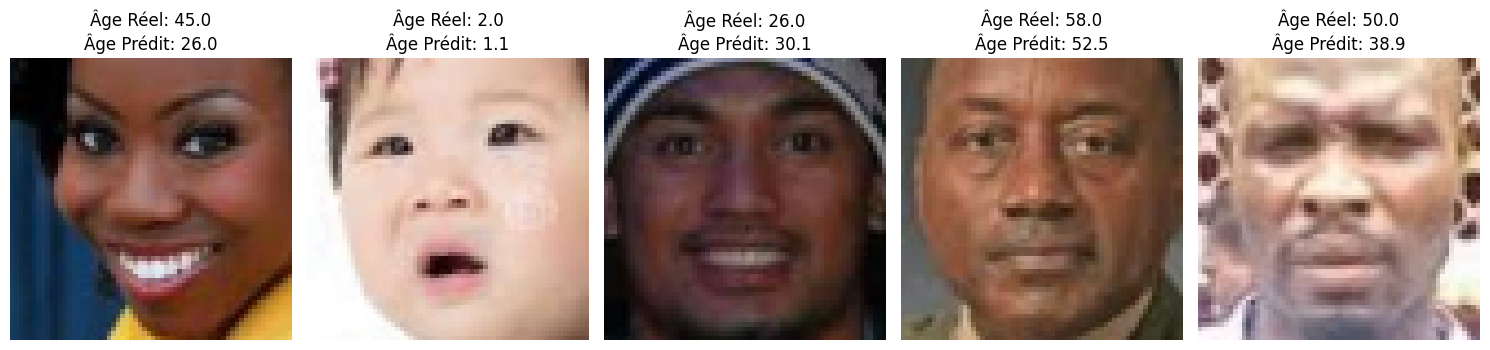

In [55]:
def visualize_predictions(X, y_true, y_pred, n=5):
    """
    Affiche n images avec l'âge réel et l'âge prédit.
    """
    import random
    indices = random.sample(range(len(X)), n)  # Sélection aléatoire d'images
    plt.figure(figsize=(15, 3*n))

    for i, idx in enumerate(indices):
        ax = plt.subplot(1, n, i+1)
        img = X[idx]  # Image correspondante
        plt.imshow(img)
        real_age = y_true[idx]  # Âge réel
        pred_age = y_pred[idx]  # Âge prédit
        ax.set_title(f"Âge Réel: {real_age:.1f}\nÂge Prédit: {pred_age:.1f}")
        ax.axis('off')  # Supprime les axes

    plt.tight_layout()
    plt.show()

#Test
visualize_predictions(X_test, y_test, y_pred_v1_test, n=5)

#Validation
visualize_predictions(X_val, y_val, y_pred_v1_val, n=5)


# Implémentation 2

Dans cette V2, plusieurs modifications ont été apportées par rapport à la V1 pour améliorer la précision des prédictions d'âge.

L’objectif principal était de revoir les tranches d’âge et d'améliorer l’architecture du modèle CNN.

Dans la V1, les tranches d’âge étaient trop nombreuses et contenaient trop peu d’exemples pour certaines catégories, ce qui a probablement entraîné une mauvaise performance du modèle.

Dans la V2, nous avons regroupé certaines tranches pour obtenir des catégories plus équilibrées.

In [58]:
age_brackets = [
    (0, 3),    # Nourrissons
    (4, 9),    # Jeune enfant
    (10, 19),  # Adolescents
    (20, 39),  # Jeunes adultes (fusion de 20-29 et 30-39)
    (40, 59),  # Adultes (fusion de 40-49 et 50-59)
    (60, 116)  # Seniors (fusion de 60-69, 70-79 et 80-116)
]

Par rapport à la V1, nous y avons ajouté un 5ᵉ bloc convolutionnel (Conv2D(256)) dans la V2.

In [60]:
# Modèle de la première consigne, adapté pour la régression d'âge

def build_model_age_v2(input_shape=(IMG_HEIGHT, IMG_WIDTH,3)):
    model = Sequential([
        # Data Augmentation
        Input(shape=input_shape),
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),

        # Bloc 1
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 2
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 3
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 4
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),


        # Bloc 5
        Conv2D(256, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        # Sortie régression => 1 neurone (pas de sigmoid)
        Dense(1)
    ])

    # Compilation : Utilisation de MAE comme fonction de perte pour la régression
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mae',
        metrics=['mae']
    )
    return model


model_v2 = build_model_age_v2((IMG_HEIGHT, IMG_WIDTH, 3))
model_v2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_4 (RandomFlip)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_4 (RandomRotation)   │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_4 (RandomZoom)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1024)                │              

 Total params: 658,273 (2.51 MB)

 Trainable params: 656,769 (2.51 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [62]:
# Callbacks: EarlyStopping + ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

history_v2 = model_v2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 155s 294ms/step - loss: 28.3115 - mae: 28.3115 - val_loss: 16.2695 - val_mae: 16.2695 - learning_rate: 0.0010
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 133s 275ms/step - loss: 12.3248 - mae: 12.3248 - val_loss: 10.1469 - val_mae: 10.1469 - learning_rate: 0.0010
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 131s 277ms/step - loss: 10.7634 - mae: 10.7634 - val_loss: 8.9420 - val_mae: 8.9420 - learning_rate: 0.0010
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 148s 289ms/step - loss: 9.7303 - mae: 9.7303 - val_loss: 9.2991 - val_mae: 9.2991 - learning_rate: 0.0010
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 138s 282ms/step - loss: 9.4647 - mae: 9.4647 - val_loss: 9.6573 - val_mae: 9.6573 - learning_rate: 0.0010
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 135s 285ms/step - loss: 9.2810 - mae: 9.2810 - val_loss: 10.6174 - val_mae: 10.6174 - learning_rate: 0.0010
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 137s 275ms/step - loss: 8.6990 - mae: 8.6990 - val_loss: 9.0876 - val_ma

### Analyse des métriques

Voici les résultats obtenus après l’entraînement du modèle V2 sur l’ensemble de test.

L’objectif est d’analyser si les modifications apportées (nouvelles tranches d’âge et nouvelle couche) ont permis d’améliorer les performances par rapport à la V1.



In [63]:
test_loss_v2, test_mae_v2 = model_v2.evaluate(X_test, y_test, verbose=0)
print(f"[V2] Test Loss (MAE): {test_loss_v2:.4f}")

y_pred_v2_test = model_v2.predict(X_test).flatten()
y_pred_brackets_v2_test = [bracket_index(int(round(age_pred))) for age_pred in y_pred_v2_test]
y_test_brackets_v2 = [bracket_index(int(age_true)) for age_true in y_test]

valid_idx_test = [i for i, br in enumerate(y_pred_brackets_v2_test) if br is not None]
y_pred_brackets_v2_test_valid = np.array([y_pred_brackets_v2_test[i] for i in valid_idx_test], dtype=int)
y_test_brackets_v2_valid = np.array([y_test_brackets_v2[i] for i in valid_idx_test], dtype=int)

acc_brackets_v2_test = accuracy_score(y_test_brackets_v2_valid, y_pred_brackets_v2_test_valid)
print("\n[V2] Accuracy  :", acc_brackets_v2_test)

print("\n[V2] Classification report sur les tranches d'âge sur TEST:")
print(classification_report(y_test_brackets_v2_valid, y_pred_brackets_v2_test_valid))

[V2] Test Loss (MAE): 6.3742
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step

[V2] Accuracy  : 0.7132196162046909

[V2] Classification report sur les tranches d'âge sur TEST:
              precision    recall  f1-score   support

           0       0.85      0.64      0.73       334
           1       0.46      0.45      0.46       253
           2       0.40      0.32      0.36       296
           3       0.81      0.86      0.83      2336
           4       0.58      0.55      0.57       956
           5       0.69      0.74      0.72       515

    accuracy                           0.71      4690
   macro avg       0.63      0.60      0.61      4690
weighted avg       0.71      0.71      0.71      4690



Le MAE est passé de 7.01 à 6.37, ce qui signifie que l’erreur moyenne de prédiction d’âge a diminué.

L’accuracy a bondi de 0.45 à 0.71, confirmant une meilleure classification des tranches d'âge.


- Les prédictions des jeunes adultes (20-39 ans) sont excellentes (Précision 0.81, Rappel 0.86, F1-score 0.83).

- La tranche des seniors (60-116 ans) a une meilleure performance (F1-score 0.72) qu’en V1, signe d’une meilleure distinction.

- Les nourrissons (0-3 ans) ont une très bonne précision (0.85), ce qui montre que la V2 est plus efficace pour identifier les très jeunes visages.

Cependant, les enfants (4-9 ans) et les adolescents (10-19 ans) ont encore une précision faible (~0.40), ce qui signifie que ces classes restent difficiles à prédire.

En bref, toutes les tranches d’âge ont vu leur F1-score s’améliorer.

In [64]:
val_loss_v2, val_mae_v2 = model_v2.evaluate(X_val, y_val, verbose=0)
print(f"[V2] Validation Loss (MAE): {val_loss_v2:.4f}")

y_pred_v2_val = model_v2.predict(X_val).flatten()
y_pred_brackets_v2_val = [bracket_index(int(round(age_pred))) for age_pred in y_pred_v2_val]
y_val_brackets_v2 = [bracket_index(int(age_true)) for age_true in y_val]

valid_idx_val = [i for i, br in enumerate(y_pred_brackets_v2_val) if br is not None]
y_pred_brackets_v2_val_valid = np.array([y_pred_brackets_v2_val[i] for i in valid_idx_val], dtype=int)
y_val_brackets_v2_valid = np.array([y_val_brackets_v2[i] for i in valid_idx_val], dtype=int)

acc_brackets_v2_val = accuracy_score(y_val_brackets_v2_valid, y_pred_brackets_v2_val_valid)
print("\n[V2] Accuracy  sur VALIDATION :", acc_brackets_v2_val)

print("\n[V2] Classification report sur les tranches d'âge sur VALIDATION:")
print(classification_report(y_val_brackets_v2_valid, y_pred_brackets_v2_val_valid))


[V2] Validation Loss (MAE): 6.1799
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step

[V2] Accuracy  sur VALIDATION : 0.7223113964686998

[V2] Classification report sur les tranches d'âge sur VALIDATION:
              precision    recall  f1-score   support

           0       0.89      0.58      0.70       254
           1       0.47      0.57      0.52       182
           2       0.47      0.34      0.39       254
           3       0.82      0.87      0.84      1895
           4       0.56      0.55      0.56       714
           5       0.72      0.73      0.72       439

    accuracy                           0.72      3738
   macro avg       0.65      0.61      0.62      3738
weighted avg       0.72      0.72      0.72      3738



L’objectif ici est de vérifier si les améliorations observées sur le jeu de test se confirment sur le jeu de validation.

Cela nous permet d’évaluer si le modèle est stable et généralisable.

- Le MAE a encore diminué (6.18 contre 6.87 en V1) : le modèle fait en moyenne une erreur plus faible sur l'âge.

- L’accuracy sur les tranches d’âges est passée de 0.46 (V1) à 0.72 (V2), signe d'une amélioration de la classification.

- Le Macro F1-score est passé de 0.38 à 0.62.


En d'autres termes, fusionner certaines tranches a permis d'avoir plus d’exemples par classe, améliorant ainsi la généralisation.


### Visualisations : diagrammes de points, courbes d'apprentissage

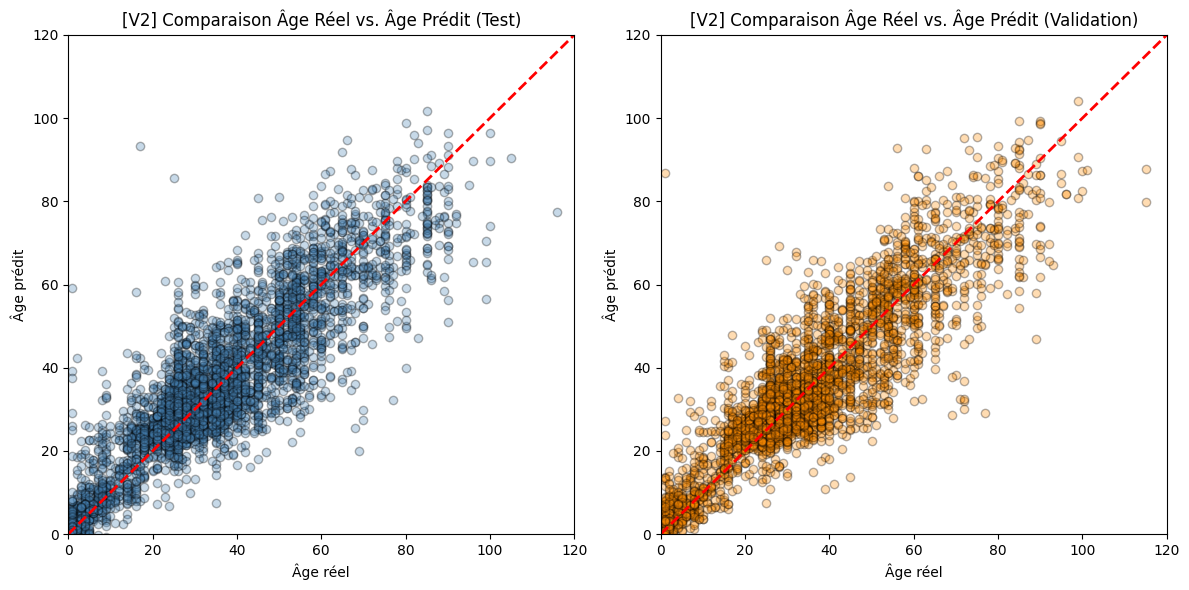

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))  # 1 ligne, 2 colonnes

# Scatter plot : Comparaison âge réel vs âge prédit (TEST)
axes[0].scatter(y_test, y_pred_v2_test, alpha=0.3, color='steelblue', edgecolor='k')
axes[0].plot([0,120],[0,120], color='red', linestyle='--', linewidth=2)  # Diagonale parfaite
axes[0].set_xlabel("Âge réel")
axes[0].set_ylabel("Âge prédit")
axes[0].set_title("[V2] Comparaison Âge Réel vs. Âge Prédit (Test)")
axes[0].set_xlim([0,120])
axes[0].set_ylim([0,120])

# Scatter plot : Comparaison âge réel vs âge prédit (VALIDATION)
axes[1].scatter(y_val, y_pred_v2_val, alpha=0.3, color='darkorange', edgecolor='k')
axes[1].plot([0,120],[0,120], color='red', linestyle='--', linewidth=2)  # Diagonale parfaite
axes[1].set_xlabel("Âge réel")
axes[1].set_ylabel("Âge prédit")
axes[1].set_title("[V2] Comparaison Âge Réel vs. Âge Prédit (Validation)")
axes[1].set_xlim([0,120])
axes[1].set_ylim([0,120])

plt.tight_layout()  # Ajuste l'espacement entre les graphiques
plt.show()


Les deux graphiques présentent une distribution similaire, ce qui indique que le modèle généralise bien et ne souffre pas de surapprentissage.

La tendance à sous-estimer les âges avancés est présente dans les deux ensembles, confirmant que c’est une faiblesse du modèle.

En effet, la majorité des points après 60 ans se situent sous la diagonale, ce qui signifie que le modèle prédit des âges trop jeunes pour ces visages.

Cependant, concernant les âges 20-39 ans, les points sont bien alignés sur la diagonale, confirmant que le modèle est performant pour cette tranche d’âge.

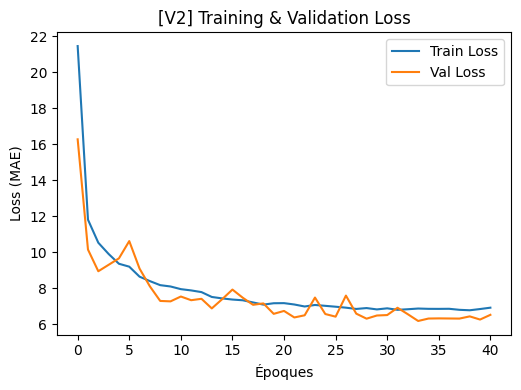

In [70]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_v2.history['loss'], label='Train Loss')
plt.plot(history_v2.history['val_loss'], label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.title('[V2] Training & Validation Loss')

plt.tight_layout()
plt.show()


Ce graphique représente l’évolution de la loss (MAE - Mean Absolute Error) au cours des époques pour l'entraînement et la validation du modèle V2.

L’objectif est d’évaluer la convergence du modèle, son potentiel surapprentissage et sa stabilité.

Entre 0 et 5 époques, la loss chute rapidement. Cela indique que le modèle apprend efficacement dès le départ.

Après 10-15 époques, la loss commence à se stabiliser autour de 6-7 MAE.

La convergence est bien visible, montrant que le modèle a atteint un plateau d'apprentissage.

Le modèle n'a pas l'air de souffrir d'overfitting.

La validation loss ne remonte pas en fin d’entraînement, ce qui signifie que le modèle ne mémorise pas trop les données d'entraînement.

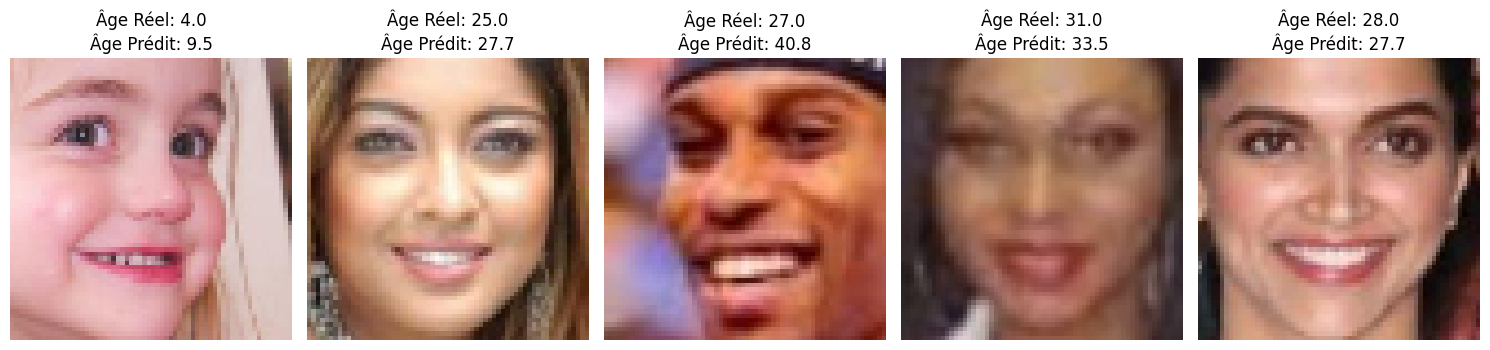

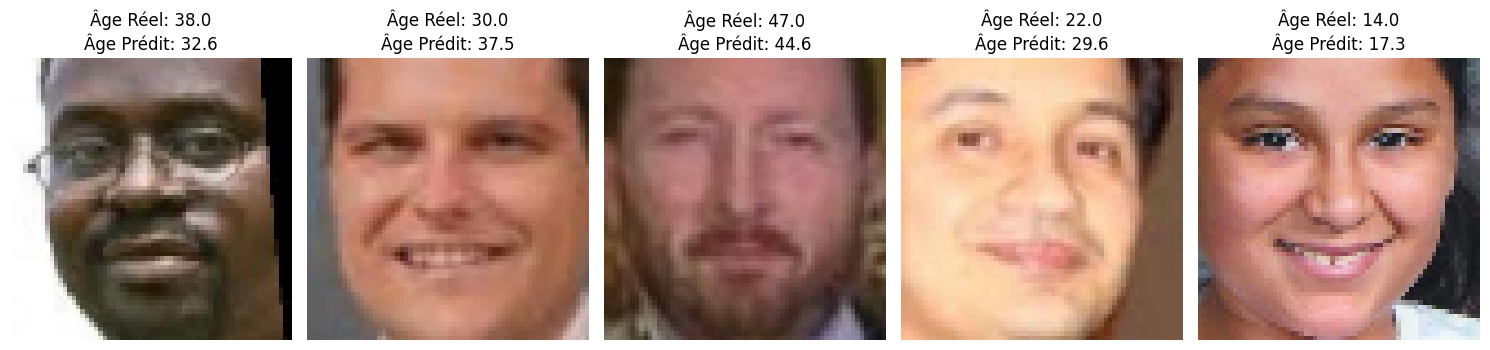

In [67]:
def visualize_predictions(X, y_true, y_pred, n=5):
    """
    Affiche n images avec l'âge réel et l'âge prédit.
    """
    import random
    indices = random.sample(range(len(X)), n)  # Sélection aléatoire d'images
    plt.figure(figsize=(15, 3*n))

    for i, idx in enumerate(indices):
        ax = plt.subplot(1, n, i+1)
        img = X[idx]  # Image correspondante
        plt.imshow(img)
        real_age = y_true[idx]  # Âge réel
        pred_age = y_pred[idx]  # Âge prédit
        ax.set_title(f"Âge Réel: {real_age:.1f}\nÂge Prédit: {pred_age:.1f}")
        ax.axis('off')  # Supprime les axes

    plt.tight_layout()
    plt.show()

# Test
visualize_predictions(X_test, y_test, y_pred_v2_test, n=5)

# Validation
visualize_predictions(X_val, y_val, y_pred_v2_val, n=5)


En conclusion, le modèle V2 apprend plus rapidement que la V1 en plus de montrer de meilleur résultat.

De ce fait, nous sauvegarderons la V2.

In [73]:
model_v2.save("model_v2_Q2.keras")

In [74]:
from google.colab import files
files.download("model_v2_Q2.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>